## Redes neuronales informadas por la física (PINNs)

### Descripción desde Towards to data science

En las últimas décadas, las redes neuronales artificiales se han utilizado para resolver problemas en diversos dominios aplicados, como la visión por computadora, el procesamiento del lenguaje natural y muchos más. Recientemente, ha surgido otra aplicación muy prometedora en la comunidad de aprendizaje automático científico (ML): la solución de ecuaciones diferenciales parciales (PDEs) utilizando redes neuronales artificiales, con un enfoque comúnmente conocido como redes neuronales informadas por la física (PINNs). Las PINNs se introdujeron originalmente en el trabajo seminal en [1] y hoy en día ya no están limitadas a un tema puramente de investigación, sino que están ganando tracción en la industria, lo suficiente como para entrar en el famoso ciclo de sobreexpectación de Gartner para tecnologías emergentes en 2021.

Las PDEs juegan un papel crucial en muchos campos de la ingeniería y la ciencia fundamental, que van desde la dinámica de fluidos hasta la ingeniería acústica y estructural. Los métodos de modelado de elementos finitos (FEM) son los solucionadores estándar empleados de manera ubicua en la industria. A pesar de su popularidad, los métodos FEM presentan algunas limitaciones, como su costo computacional para problemas industriales grandes (principalmente debido al tamaño de la malla requerida) y problemas para aprovechar fuentes de datos externas, como datos de sensores, para guiar la solución de las PDEs.

El enfoque de las PINNs discutido en esta publicación se considera una alternativa prometedora a los métodos FEM para cubrir algunas de estas limitaciones. Este enfoque es bastante diferente del ML supervisado estándar. De hecho, en lugar de depender únicamente de los datos, utiliza las propiedades físicas de la PDE en sí para guiar el proceso de entrenamiento. Los puntos de datos conocidos se pueden agregar fácilmente sobre la función de pérdida basada en la física para acelerar la velocidad de entrenamiento.

ENLACE: [Towards Data Science](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4)

### Descripción desde el abstract del paper inicial

Introducimos las redes neuronales informadas por la física (PINNs) – redes neuronales que se entrenan para resolver tareas de aprendizaje supervisado respetando cualquier ley de la física descrita por ecuaciones diferenciales parciales no lineales generales. En este trabajo, presentamos nuestros desarrollos en el contexto de la resolución de dos clases principales de problemas: solución basada en datos y descubrimiento basado en datos de ecuaciones diferenciales parciales. Dependiendo de la naturaleza y disposición de los datos disponibles, ideamos dos tipos distintos de algoritmos, a saber, modelos de tiempo continuo y modelos de tiempo discreto. El primer tipo de modelos forma una nueva familia de aproximadores de funciones espacio-temporales eficientes en términos de datos, mientras que el segundo tipo permite el uso de esquemas de integración temporal implícitos de Runge-Kutta con precisión arbitraria y un número ilimitado de etapas. La efectividad del marco propuesto se demuestra a través de una colección de problemas clásicos en fluidos, mecánica cuántica, sistemas de reacción-difusión y la propagación de ondas no lineales en aguas someras.

# Descripción con textos anteriores y Gemini

## Introducción al proyecto: Redes neuronales informadas por la física (PINNs)

En los últimos años, las redes neuronales artificiales (ANNs) se han convertido en una poderosa herramienta para resolver problemas complejos en diversos dominios científicos y de ingeniería. Una aplicación particularmente prometedora es el uso de ANNs para resolver ecuaciones diferenciales parciales (EDPs), un enfoque conocido como redes neuronales informadas por la física (PINNs). Introducidas en [1], las PINNs ofrecen una alternativa convincente a los métodos tradicionales como el modelado por elementos finitos (FEM) para resolver EDPs. Si bien el FEM se usa ampliamente en la industria, puede ser computacionalmente costoso para problemas grandes y tener dificultades para incorporar fuentes de datos externas como las mediciones de sensores. Las PINNs abordan estas limitaciones al combinar el aprendizaje basado en datos con las leyes físicas rectoras encapsuladas en las EDPs mismas. Esto permite que las PINNs no solo aprendan de los datos disponibles, sino que también aprovechen la física inherente para guiar el proceso de entrenamiento. Este enfoque único tiene un gran potencial para diversos campos, que incluyen la dinámica de fluidos, la acústica, la ingeniería estructural y más.

* **Dinámica de fluidos:** Simulación de flujo de fluidos, como el flujo de aire alrededor de un ala de avión o el flujo de agua en una tubería.
* **Acústica:** Modelado de propagación de ondas sonoras, como el diseño de salas de conciertos o la reducción de ruido en motores.
* **Ingeniería estructural:** Análisis de tensiones y deformaciones en estructuras, como puentes, edificios y aviones.
* **Mecánica cuántica:** Simulación de sistemas cuánticos, como el comportamiento de átomos y moléculas.
* **Sistemas de reacción-difusión:** Modelado de reacciones químicas y difusión, como el crecimiento de cristales o la corrosión de metales.
* **Propagación de ondas de aguas poco profundas no lineales:** Simulación de olas en el océano, como olas generadas por tormentas o tsunamis.


A continuación, se implementará una PINN para resolver una EDO, en particular la de crecimiento logístico. El objetivo de esta implementación es realizar un primer acercamiento al problema y al método. El lineamiento de lo siguiente viene desde la siguiente [publicación](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4) , los comentarios y variaciones son elaboración propia.

Para mantener las cosas simples, en esta publicación nos enfocamos en la ecuación diferencial logística, una famosa ecuación diferencial ordinaria de primer orden utilizada para modelar el crecimiento de la población:
$$
\frac{df(T)}{dt} = Rf(t)(1-f(t))
$$

Aquí, la función \( f(t) \) representa la tasa de crecimiento de la población a lo largo del tiempo \( t \) y el parámetro \( R \) proporciona la tasa máxima de crecimiento de la población y afecta fuertemente la forma de la solución. Para especificar completamente la solución de esta ecuación, es necesario imponer una condición de frontera, por ejemplo, en \( t = 0 \) tal como:

$$
f(0) = 0.5 
$$

Aunque la solución de esta ecuación puede derivarse fácilmente de manera analítica, representa un campo de prueba simple para ilustrar cómo funcionan las PINNs. Todas las técnicas explicadas a continuación son aplicables de inmediato a ecuaciones diferenciales ordinarias y parciales más complejas. Sin embargo, para escenarios más complejos se necesitarán trucos adicionales para lograr una buena convergencia.

Las PINNs se basan en dos propiedades fundamentales de las redes neuronales (NN):

1. Se ha demostrado formalmente [2] que las redes neuronales son aproximadores universales de funciones. Por lo tanto, una red neuronal, siempre que sea lo suficientemente profunda y expresiva, puede aproximar cualquier función y, por lo tanto, también la solución para la ecuación diferencial anterior.
2. Es fácil y económico calcular las derivadas (de cualquier orden) de la salida de una red neuronal con respecto a cualquiera de sus entradas (y, por supuesto, a los parámetros del modelo durante la retropropagación) utilizando la diferenciación automática (AD). De hecho, la AD es lo que hizo que las redes neuronales fueran tan eficientes y exitosas en primer lugar.

Estas son características interesantes, pero ¿cómo podemos hacer que la red neuronal realmente aprenda la solución? Y aquí viene la idea sorprendentemente simple pero extremadamente ingeniosa detrás de las PINNs [3, 4]: Podemos construir la función de pérdida de la red neuronal de manera que, cuando se minimice, la PDE se satisfaga automáticamente. En otras palabras, la contribución más importante de la pérdida se toma como el residuo de la ecuación diferencial de la siguiente manera:

$$
\frac{df_{NN}(T)}{dt} - Rf_{NN}(t)(1-f_{NN}(t)) = 0
$$

donde $f_{NN}(t)$ es la salida de una red neuronal con una entrada y su derivada se calcula utilizando AD. Es inmediato ver que si la salida de la red neuronal respeta la ecuación anterior, uno está realmente resolviendo la ecuación diferencial. Para calcular la contribución real de la pérdida proveniente del residuo de la DE, es necesario especificar un conjunto de puntos en el dominio de la ecuación (generalmente conocidos como puntos de colocación) y evaluar el error cuadrático medio (MSE) u otra función de pérdida como un promedio sobre todos los puntos de colocación elegidos:

$$
\mathcal{L} _{DE}= \frac{1}{M} \sum_{j=1}^M\left( \frac{df_{NN}(t)}{dt}\Big|_{t_{j}} - Rf_{NN}(t_j)(1-f_{NN}(t_j)) \right)^2
$$

Sin embargo, una pérdida basada solo en el residuo anterior no garantiza tener una solución única para la ecuación. Por lo tanto, incluyamos la condición de frontera añadiéndola al cálculo de la pérdida de la misma manera que antes:

$$
\mathcal{L}_{BC} = (f_{NN}(t_0)-0.5)^2 \hspace{5pt} \text{con } t_0 = 0
$$

Por lo tanto, la forma final de la función de pérdida será:

$$
\mathcal{L} = \mathcal{L}_{DE} + \mathcal{L}_{BC}
$$

El marco de trabajo de PINNs es muy flexible y, utilizando las ideas presentadas anteriormente, uno puede agregar más condiciones de frontera, incluir condiciones más complejas como restricciones en las derivadas de $f(x)$, o tratar problemas dependientes del tiempo y multidimensionales utilizando una red neuronal con múltiples entradas.

Veamos ahora cómo construir dicha función de pérdida con una red neuronal simple construida con PyTorch.

In [1]:
from typing import Callable
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
import torchopt
from collections import OrderedDict
from torch.func import functional_call, grad, vmap
import scipy.io
import warnings
import plotly.graph_objects as go
warnings.filterwarnings("ignore")

torch.manual_seed(42)

W0605 18:50:23.535000 16952 torch\distributed\elastic\multiprocessing\redirects.py:27] NOTE: Redirects are currently not supported in Windows or MacOs.


In [4]:
# Implementación de PINNs para una EDO con Pytorch

class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 1,
        num_neurons: int = 5,
        act: nn.Module = nn.Tanh(),
    ) -> None:
        """Arquitectura básica de red neuronal con capas lineales
        
        Args:
            num_inputs (int, opcional): la dimensionalidad del tensor de entrada
            num_layers (int, opcional): el número de capas ocultas
            num_neurons (int, opcional): el número de neuronas para cada capa oculta
            act (nn.Module, opcional): la función de activación no lineal a utilizar para conectar
                las capas lineales
        """
        super().__init__()
        
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # capa de entrada
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # capas ocultas con capa lineal y activación
        for _ in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons), act])

        # capa de salida
        layers.append(nn.Linear(num_neurons, 1))

        # construir la red
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()
    
def make_forward_fn(
    model: nn.Module,
    derivative_order: int = 1,
    ) -> list[Callable]:
        """Crear una función de pase hacia adelante y funciones de gradiente para un modelo dado

        Esta función crea un conjunto de llamadas funcionales del modelo de entrada
    
        Devuelve una lista de versiones v-mapeadas composables del pase hacia adelante
        y de derivadas de orden superior con respecto a las entradas según lo especificado
        por el argumento de entrada `derivative_order`
    
        Args:
            model (nn.Module): el modelo para crear las llamadas funcionales. Puede ser cualquier subclase de
                nn.Module
            derivative_order (int, opcional): Hasta qué orden se devuelven las funciones para calcular la
                derivada del modelo con respecto a las entradas
    
        Returns:
            list[Callable]: Una lista de funciones donde cada elemento corresponde a
                una versión v-mapeada del pase hacia adelante del modelo y sus derivadas. El
                0-ésimo elemento es siempre el pase hacia adelante y, dependiendo del valor del
                argumento `derivative_order`, los siguientes elementos corresponden a
                la función de derivada de i-ésimo orden con respecto a las entradas del modelo. El
                vmap asegura soporte eficiente para entradas en lotes
        """
        def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter] | tuple[torch.nn.Parameter, ...]) -> torch.Tensor:
            if isinstance(params, tuple):
                params_dict = tuple_to_dict_parameters(model, params)
            else:
                params_dict = params
            return functional_call(model, params_dict, (x, ))

        fns = []
        fns.append(f)

        dfunc = f
        for _ in range(derivative_order):
            dfunc = grad(dfunc)
            dfunc_vmap = vmap(dfunc, in_dims=(0, None))
            fns.append(dfunc_vmap)
        return fns

def tuple_to_dict_parameters(
        model: nn.Module, params: tuple[torch.nn.Parameter, ...]
) -> OrderedDict[str, torch.nn.Parameter]:
    """Convertir un conjunto de parámetros almacenados como una tupla en una forma de diccionario

    Esta conversión es necesaria para poder llamar a la API `functional_call` que requiere
    parámetros en forma de diccionario a partir de los resultados de un paso de optimización funcional que 
    devuelve los parámetros como una tupla

    Args:
        model (nn.Module): el modelo para crear las llamadas funcionales. Puede ser cualquier subclase de
            nn.Module
        params (tuple[Parameter, ...]): los parámetros del modelo almacenados como una tupla
    
    Returns:
        Una instancia de OrderedDict con los parámetros almacenados como un diccionario ordenado
    """
    keys = list(dict(model.named_parameters()).keys())
    values = list(params)
    return OrderedDict(({k:v for k,v in zip(keys, values)}))

Las PINNs son un área de investigación muy activa y se han ideado arquitecturas de redes neuronales mucho más complejas y a menudo adaptadas a problemas específicos. La discusión sobre estas arquitecturas está fuera de esta parte introductoria.

Construir la función de pérdida:

Ahora que hemos definido nuestro aproximador universal de funciones, vamos a construir la función de pérdida. Como se discutió, esta se compone del término residual de la ecuación diferencial, que actúa como una regularización informada por la física, y el término de la condición de frontera, que guía a la red para converger a la solución deseada entre las infinitas posibles.

Primero, es necesario elegir un conjunto de puntos de colocación. Dado que estamos resolviendo un problema muy simple, podemos elegir una cuadrícula uniformemente espaciada en el dominio del tiempo: `t = torch.linspace(0, 1, steps=30, requires_grad=True)` o podemos muestrear aleatoriamente nuevos puntos de colocación del dominio del tiempo en cada iteración del optimizador. Para problemas más complejos, la elección de puntos de colocación es extremadamente importante y puede afectar fuertemente los resultados.

Para calcular la salida del modelo y su derivada estamos utilizando la API funcional de PyTorch, que hace que los modelos sean totalmente funcionales al desacoplar los parámetros del propio modelo.

El enfoque funcional en PyTorch es muy conveniente cuando se trata de derivadas (de orden superior) de la salida de la red neuronal con respecto a sus entradas, como es a menudo el caso para las PINNs. En el código a continuación, usamos la API `torch.func` introducida en PyTorch 2.0 para construir un pase hacia adelante funcional y cálculos de gradiente de orden superior con soporte para lotes.

In [5]:
from torch.func import functional_call, grad, vmap

model = LinearNN()

# note que `functional_call` soporta entradas en lotes por defecto
# por lo tanto, no es necesario llamar a vmap en él, como es el caso
# para las llamadas a las derivadas
def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params_dict, (x, ))

# función para calcular gradientes de orden superior con respecto
# a la entrada simplemente componiendo llamadas `grad` y usando nuevamente `vmap` para
# un lote eficiente de la entrada
dfdx = vmap(grad(f), in_dims=(0, None))
d2fdx2 = vmap(grad(grad(f)), in_dims=(0, None))

Notar que las llamadas a `grad` se pueden componer sin restricciones, permitiendo así calcular derivadas de cualquier orden con respecto a las entradas. Usando las funciones definidas anteriormente, la pérdida MSE se calcula fácilmente como una suma de la contribución de la ecuación diferencial en cada punto de colocación y la contribución de la condición de frontera. Dado que el forward pass y las derivadas son de naturaleza funcional, la función de pérdida también debe tomar los parámetros del modelo como argumento de entrada

In [6]:
R = 1.0  # tasa de crecimiento máximo de la población que parametriza la ecuación
X_BOUNDARY = 0.0  # coordenada de la condición de frontera
F_BOUNDARY = 0.5  # valor de la condición de frontera

def make_loss_fn(f: Callable, dfdx: Callable) -> Callable:
    """Crear una función de evaluación de pérdida

    La pérdida se calcula como la suma de la pérdida MSE interior (el residuo de la ecuación diferencial)
    y el MSE de la pérdida en la frontera

    Args:
        f (Callable): El pase hacia adelante funcional del modelo utilizado como aproximador universal de funciones. Esta
            es una función con la firma (x, params) donde `x` son los datos de entrada y `params` los parámetros del modelo.
        dfdx (Callable): El cálculo funcional del gradiente del aproximador universal de funciones. Esta
            es una función con la firma (x, params) donde `x` son los datos de entrada y `params` los parámetros del modelo.

    Returns:
        Callable: La función de pérdida con la firma (params, x) donde `x` son los datos de entrada y `params` los parámetros
            del modelo. Nota que una simple llamada a `dloss = functorch.grad(loss_fn)` daría el gradiente
            de la pérdida con respecto a los parámetros del modelo necesarios para los optimizadores.
    """

    def loss_fn(params: torch.Tensor, x: torch.Tensor):
        f_value = f(x, params)
        interior = dfdx(x, params) - R * f_value * (1 - f_value)
        x0 = X_BOUNDARY
        f0 = F_BOUNDARY
        x_boundary = torch.tensor([x0])
        f_boundary = torch.tensor([f0])
        boundary = f(x_boundary, params) - f_boundary

        loss = nn.MSELoss()
        loss_value = loss(interior, torch.zeros_like(interior)) + loss(
            boundary, torch.zeros_like(boundary)
        )

        return loss_value

    return loss_fn

Iteración 0 con pérdida 0.6875214576721191
Iteración 1 con pérdida 0.07539822161197662
Iteración 2 con pérdida 0.061332348734140396
Iteración 3 con pérdida 0.06273966282606125
Iteración 4 con pérdida 0.060336850583553314
Iteración 5 con pérdida 0.06283889710903168
Iteración 6 con pérdida 0.061326973140239716
Iteración 7 con pérdida 0.05547821894288063
Iteración 8 con pérdida 0.056063998490571976
Iteración 9 con pérdida 0.046896230429410934
Iteración 10 con pérdida 0.034501418471336365
Iteración 11 con pérdida 0.023010648787021637
Iteración 12 con pérdida 0.013984388671815395
Iteración 13 con pérdida 0.040047187358140945
Iteración 14 con pérdida 0.01831713318824768
Iteración 15 con pérdida 0.011284725740551949
Iteración 16 con pérdida 0.022073935717344284
Iteración 17 con pérdida 0.029716862365603447
Iteración 18 con pérdida 0.0209547970443964
Iteración 19 con pérdida 0.015735674649477005
Iteración 20 con pérdida 0.013831011950969696
Iteración 21 con pérdida 0.006837353575974703
Iteraci

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteración 139 con pérdida 1.1913220077985898e-05
Iteración 140 con pérdida 6.813026629970409e-06
Iteración 141 con pérdida 7.605216069350718e-06
Iteración 142 con pérdida 1.1458892004156951e-05
Iteración 143 con pérdida 5.561914349527797e-06
Iteración 144 con pérdida 1.0879574801947456e-05
Iteración 145 con pérdida 5.820836577186128e-06
Iteración 146 con pérdida 6.694889634673018e-06
Iteración 147 con pérdida 4.898935458186315e-06
Iteración 148 con pérdida 3.89174829251715e-06
Iteración 149 con pérdida 4.0133509173756465e-06


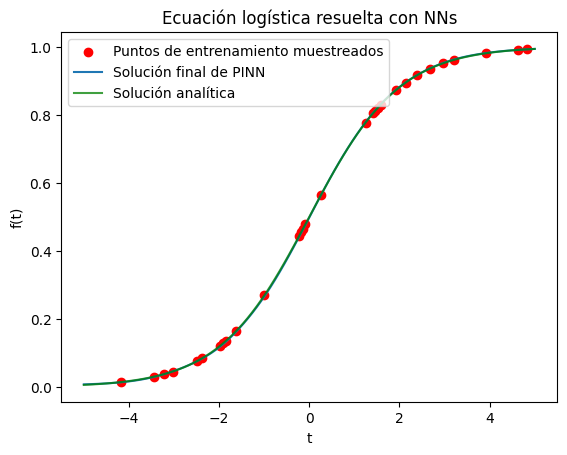

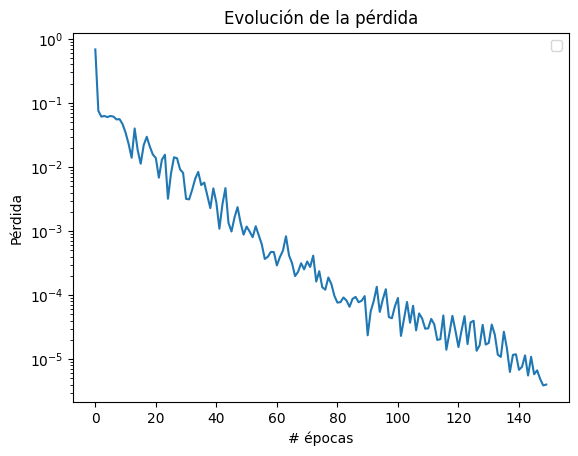

In [5]:
# Fijamos la arquitectura del MLP
num_hidden = 5
dim_hidden = 5
batch_size = 30
num_iter = 150
learning_rate = 0.1
domain = (-5.0, 5.0)

torch.manual_seed(42)

# Configuración
model = LinearNN(num_layers=num_hidden, num_neurons=dim_hidden, num_inputs=1)
funcs = make_forward_fn(model, derivative_order=1)

f = funcs[0]
dfdx = funcs[1]
loss_fn = make_loss_fn(f, dfdx)

# adam como optimizador
optimizer = torchopt.FuncOptimizer(torchopt.adam(lr=learning_rate))

# Parámetros iniciales inicializados aleatoriamente
params = tuple(model.parameters())

# Entrenamos el modelo
loss_evolution = []
for i in range(num_iter):
    # Muestreamos puntos en el dominio aleatoriamente para cada época
    x = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1])

    # Calculamos la pérdida con los parámetros actuales
    loss = loss_fn(params, x)

    # Actualizamos los parámetros con el optimizador funcional
    params = optimizer.step(loss, params)

    print(f"Iteración {i} con pérdida {float(loss)}")
    loss_evolution.append(float(loss))

# Graficamos la solución en el dominio dado
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)
f_eval = f(x_eval, params)
analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0/F_BOUNDARY - 1.0) * np.exp(-R * x))
x_eval_np = x_eval.detach().numpy()
x_sample_np = torch.FloatTensor(batch_size).uniform_(domain[0], domain[1]).detach().numpy()

fig, ax = plt.subplots()

ax.scatter(x_sample_np, analytical_sol_fn(x_sample_np), color="red", label="Puntos de entrenamiento muestreados")
ax.plot(x_eval_np, f_eval.detach().numpy(), label="Solución final de PINN")
ax.plot(
    x_eval_np,
    analytical_sol_fn(x_eval_np),
    label=f"Solución analítica",
    color="green",
    alpha=0.75,
)
ax.set(title="Ecuación logística resuelta con NNs", xlabel="t", ylabel="f(t)")
ax.legend()

fig, ax = plt.subplots()
ax.semilogy(loss_evolution)
ax.set(title="Evolución de la pérdida", xlabel="# épocas", ylabel="Pérdida")
ax.legend()

plt.show()

¡Eso es todo! La pérdida personalizada definida anteriormente asegura que después del procedimiento de entrenamiento, la red neuronal aproximará la solución a la ecuación diferencial elegida. Ahora, veámosla en acción.

Resolviendo la ecuación diferencial con PINNs
PyTorch no ofrece actualmente soporte nativo para optimizadores con la API funcional que usamos. Sin embargo, la increíble comunidad de PyTorch viene al rescate y se puede obtener una versión funcional de la mayoría de los optimizadores de PyTorch utilizando la biblioteca `torchopt`. La interfaz de esta biblioteca es muy intuitiva y resultará inmediatamente familiar para cualquier usuario de PyTorch. A continuación se muestra un bucle de entrenamiento básico para nuestro modelo funcional. Ten en cuenta que muestreamos aleatoriamente el dominio de la solución en cada iteración.

Veamos algunos resultados. Usamos el optimizador Adam con una tasa de aprendizaje de 0.1 con 30 puntos de entrenamiento muestreados uniformemente del dominio en cada época de optimización. Dada la simplicidad de la ecuación diferencial elegida, 100 épocas son suficientes para reproducir casi perfectamente el resultado analítico con una tasa de crecimiento máximo fijada en $R = 1$:

Aquí resolvimos un problema muy simple y unidimensional. Con ecuaciones más complejas, la convergencia no se logra tan fácilmente. Particularmente para problemas dependientes del tiempo, se han ideado muchos trucos útiles en los últimos años, como descomponer el dominio de la solución en diferentes partes resueltas utilizando diferentes redes neuronales, ponderación inteligente de diferentes contribuciones de pérdida para evitar converger a soluciones triviales y muchos más. Introduciré algunos de estos trucos en publicaciones futuras, así que mantente atento.

A continuación, se implementará una PINN para aproximar la ecuación de Burger. ###Comentar adecuadamente esta parte, en caso de ser útil

Link del [repositorio](https://github.com/HridayM25/Physics-Informed-NN) con el código

En lo siguiente se resolverá una EDP de la misma manera que se hizo antes, además de incluir en el código un parámetro que permita comparar para este caso el desempeño de un perceptrón multicapa normal con una PINN.

En este caso tenemos que la ecuación de Burger viene dada por:
\begin{align*}
u_t+uu_x -\frac{0.01}{\pi}u_{xx} &= 0 \hspace{5pt} \text{con } x\in[-1,1], t\in[0,1]\\
u(0,x) &= -sin(\pi x)\\
u(t,-1) &= u(t,1) = 0
\end{align*}

Ahora, sea $f := u_t+uu_t-\frac{0.01}{\pi}u_{xx}$, y con ello la función de error a minimizar es la siguiente:
\begin{align*}
MSE &= MSE_u + MSE_f\\
MSE_u &= \frac{1}{N_u} \sum_{i=1}^{N_u}|u(t_{iu},x_{iu})-u_i|^2\\
MSE_f &= \frac{1}{N_f} \sum_{i=1}^{N_f}|f(t_{if},x_{if})|^2\\
\end{align*}

El MSE_u corresponde a los datos iniciales y de borde, mientras que MSE_f impone la estructura impuesta por la ecuación de Burgers en un conjunto finito de puntos de colocación. Los puntos t, x con un subíndice u denotan los datos de entrenamiento iniciales y de límites en u(t, x) y los puntos t,x con un subíndice f especifican los puntos de colocación para f(t, x)

In [6]:
# Comenzamos cargando la data 
import scipy.io

#Cargamos la data
data = scipy.io.loadmat('burgers_shock.mat')
x = data['x'].flatten()[:, None]
t = data['t'].flatten()[:, None]
usol = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
train = torch.concat([torch.Tensor(X.flatten()[:, None]), torch.Tensor(T.flatten()[:, None])], 1)
X_min = train.min(0)
X_max = train.max(0)

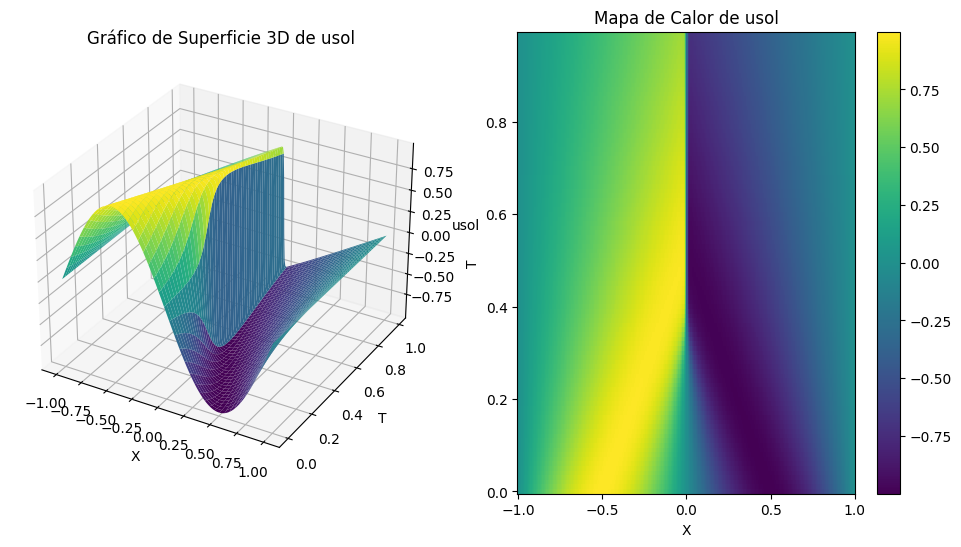

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cargamos los datos desde un archivo .mat
data = scipy.io.loadmat('burgers_shock.mat')
x = data['x'].flatten()[:, None]  # Coordenadas espaciales
t = data['t'].flatten()[:, None]  # Coordenadas temporales
usol = np.real(data['usol']).T  # Solución de la ecuación de Burgers, transpuesta para ajuste de dimensiones

# Creamos las mallas para la visualización
X, T = np.meshgrid(x, t)

# Convertimos los datos a un formato adecuado para el entrenamiento
train = torch.cat([torch.Tensor(X.flatten()[:, None]), torch.Tensor(T.flatten()[:, None])], 1)
X_min = train.min(0)[0]  # Valor mínimo de las características
X_max = train.max(0)[0]  # Valor máximo de las características

# Gráfico de superficie 3D de la solución usol
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, T, usol, cmap='viridis')
ax.set_xlabel('X')  # Etiqueta del eje X
ax.set_ylabel('T')  # Etiqueta del eje T
ax.set_zlabel('usol')  # Etiqueta del eje Z
ax.set_title('Gráfico de Superficie 3D de usol')
#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Mapa de calor de la solución usol
ax2 = fig.add_subplot(122)
c = ax2.pcolormesh(X, T, usol, shading='auto', cmap='viridis')
ax2.set_xlabel('X')  # Etiqueta del eje X
ax2.set_ylabel('T')  # Etiqueta del eje T
ax2.set_title('Mapa de Calor de usol')
fig.colorbar(c, ax=ax2)  # Barra de color para el mapa de calor
plt.show()

In [8]:
# Arriba podemos redefinir estas variables por el nombre que tienen,
# o cambiarlas en el resto del código, lo dejo así momentáneamente
# ante posibles correcciones de código
X_star = train  # Puntos de entrenamiento en el dominio
u_star = usol  # Solución de la ecuación en los puntos de entrenamiento
lb = X_min  # Límite inferior del dominio
ub = X_max  # Límite superior del dominio

In [9]:
# Red neuronal para la solución u
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # Capa totalmente conectada con 2 entradas y 16 neuronas
        self.fc2 = nn.Linear(16, 32)  # Capa totalmente conectada con 16 entradas y 32 neuronas
        self.fc3 = nn.Linear(32, 1)  # Capa de salida con 32 entradas y 1 neurona
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))  # Activación ReLU después de la primera capa
        x = nn.functional.relu(self.fc2(x))  # Activación ReLU después de la segunda capa
        x = self.fc3(x)  # Salida de la red
        return x

In [10]:
# En esta implementación, se tiene que physics es un parámetro para agregar (o no)
# los residuos a la función de pérdida
class PINN():
    def __init__(self, X, u, lb, ub, physics):
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        self.physics = physics
        
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()  # Coordenadas espaciales con gradientes requeridos
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float()  # Coordenadas temporales con gradientes requeridos
        self.u = torch.tensor(u).float()  # Solución de la ecuación
        
        self.network = Network()  # Instancia de la red neuronal
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=0.001)  # Optimizador Adam
        
    def makeNetwork(self, x, t):
        X = torch.cat([x, t], 1)  # Concatenamos las entradas espaciales y temporales
        return self.network(X)
    
    def residual(self, x, t):
        u = self.makeNetwork(x, t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # Derivada de u respecto al tiempo
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]  # Derivada de u respecto al espacio
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]  # Segunda derivada de u respecto al espacio
        
        return u_t + u * u_x - (0.01 / np.pi) * u_xx  # Residuo de la ecuación diferencial
    
    def lossResidual(self):
        u_pred = self.makeNetwork(self.x, self.t)
        residual_pred = self.residual(self.x, self.t)
        loss = torch.mean((self.u - u_pred)**2)  # Pérdida MSE entre la solución real y la predicha
        if self.physics:  # Si physics == True agregamos el término de física a la función de pérdida
            loss += torch.mean(residual_pred**2)
        self.optimizer.zero_grad()
        loss.backward()
        return loss
    
    def train(self, epochs):
        lossTracker = []
        self.network.train()
        for idx in range(epochs):
            u_pred = self.makeNetwork(self.x, self.t)
            residual_pred = self.residual(self.x, self.t)
            loss = torch.mean((self.u - u_pred)**2)
            if self.physics:
                loss += torch.mean(residual_pred**2)
            lossTracker.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.optimizer.step(self.lossResidual)
        return lossTracker
            
    def predict(self): 
        self.network.eval()
        u = self.makeNetwork(self.x, self.t)
        res = self.residual(self.x, self.t)
        return u.detach().numpy(), res.detach().numpy()  # Devolvemos las predicciones y los residuos como arrays de numpy

In [11]:
# Seleccionamos aleatoriamente 2000 puntos de X_star sin reemplazo
idx = np.random.choice(X_star.shape[0], 2000, replace=False)

# Extraemos los puntos de entrenamiento correspondientes a los índices seleccionados
X_u_train = X_star[idx, :]

# Extraemos los valores de u correspondientes a los puntos de entrenamiento
u_train = u_star.flatten()[:, None][idx, :]

In [12]:
# Inicializamos el modelo PINN con los puntos de entrenamiento y los límites del dominio
# Aquí se define physics como True
model = PINN(X_u_train, u_train, lb[0], ub[0], True)

# Entrenamos el modelo PINN por 1000 épocas
pinn = model.train(1000)

In [13]:
# Inicializamos el modelo PINN con los puntos de entrenamiento y los límites del dominio
# Aquí se define physics como False
model = PINN(X_u_train, u_train, lb[0], ub[0], False)

# Entrenamos el modelo PINN por 1000 épocas
no_pinn = model.train(1000)

In [14]:
epochs = list(range(len(pinn)))

# Crear una figura utilizando plotly
fig = go.Figure()

# Añadir traza para la evolución de la pérdida del PINN
fig.add_trace(go.Scatter(x=epochs, y=pinn, mode='lines', name='Physics Informed Neural Network'))

# Actualizar el diseño del gráfico
fig.update_layout(
    title='Pérdida vs. Épocas PINN',
    xaxis=dict(title='Épocas'),
    yaxis=dict(title='Pérdida'),
    legend=dict(x=0.7, y=1.0),
    margin=dict(l=20, r=20, t=40, b=20),
    hovermode='x unified' 
)

# Mostrar el gráfico
fig.show()

In [15]:
epochs = list(range(len(no_pinn)))

# Crear una figura utilizando plotly
fig = go.Figure()

# Añadir traza para la evolución de la pérdida del MLP sin información física
fig.add_trace(go.Scatter(x=epochs, y=no_pinn, mode='lines', name='Not Physics Informed Neural Network'))

# Actualizar el diseño del gráfico
fig.update_layout(
    title='Pérdida vs. Épocas MLP',
    xaxis=dict(title='Épocas'),
    yaxis=dict(title='Pérdida'),
    legend=dict(x=0.7, y=1.0),
    margin=dict(l=20, r=20, t=40, b=20),
    hovermode='x unified' 
)

# Mostrar el gráfico
fig.show()

Notamos que el error es consistentemente mayor en el primer gráfico, que corresponde a la función de de pérdida en la PINN. Con ello, tenemos entonces que en este caso para la red neuronal le es más fácil aproximar la solución sin imponer los residuos en la función de Loss.

## Caso EDP que no converge la PINN al aumentar el n

Código desde Tarea Nico y chatgpt



Iteration 500, Loss: 194.74603271484375
Iteration 1000, Loss: 166.9857177734375
Iteration 1500, Loss: 156.85928344726562
Iteration 2000, Loss: 155.85093688964844
Iteration 2500, Loss: 154.35824584960938
Iteration 3000, Loss: 153.72528076171875


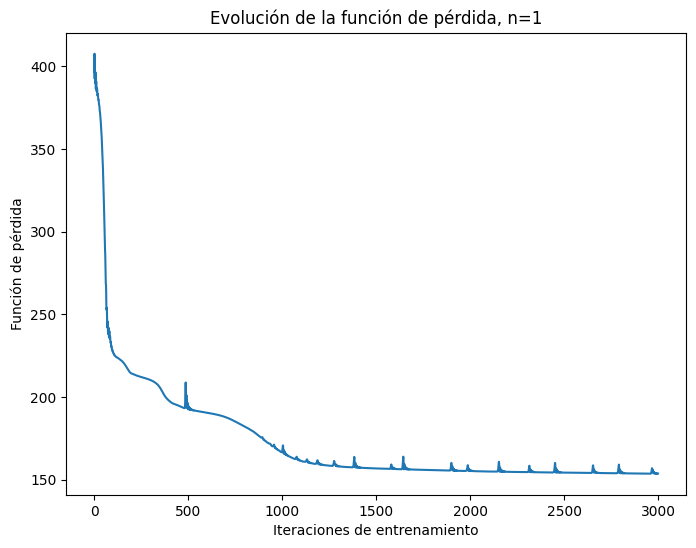

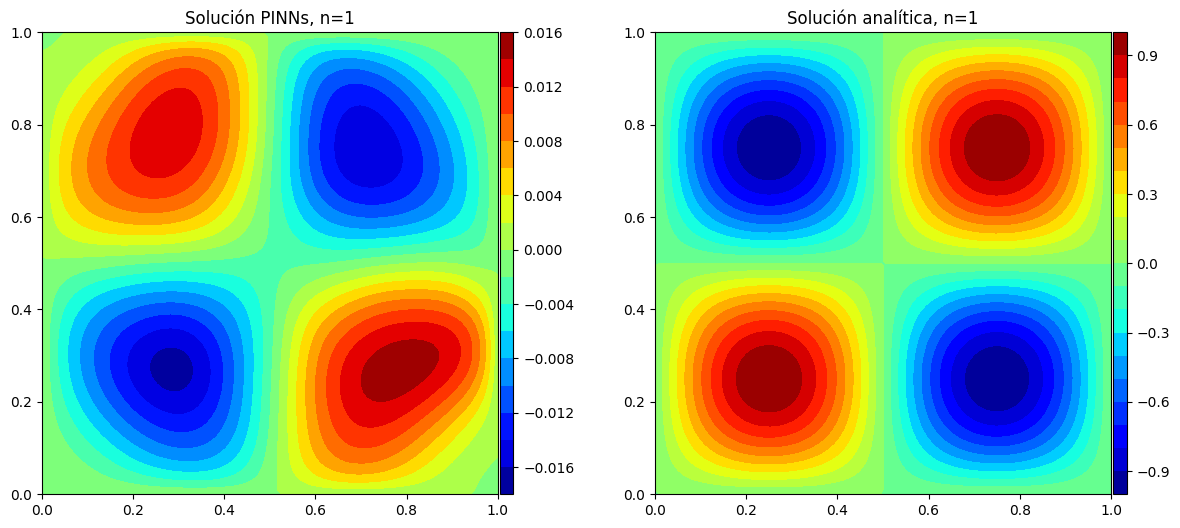

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Dimensión de input
dim_input = 2

# Dimensión de output
dim_output = 1

# Iteraciones del optimizador
iterations = 3000

# Número de onda
n = 1
k0 = 2 * np.pi * n

# Geometría del dominio
geom = [0, 1, 0, 1]

# Condición de frontera
def boundary(x):
    return (x[:, 0] == 0) | (x[:, 0] == 1) | (x[:, 1] == 0) | (x[:, 1] == 1)

# Dado que fijaremos la condición de borde, no se la daremos a la red directamente
bc = []

# Red neuronal totalmente conectada (FNN)
class FNN(nn.Module):
    def __init__(self, layers, activation):
        super(FNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Transformación para imponer la condición de borde
def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

# Ecuación en derivadas parciales (PDE)
def pde(x, y, net):
    y = net(x)
    dy_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    dy_xx = torch.autograd.grad(dy_x[:, 0], x, grad_outputs=torch.ones_like(dy_x[:, 0]), create_graph=True)[0][:, 0]
    dy_yy = torch.autograd.grad(dy_x[:, 1], x, grad_outputs=torch.ones_like(dy_x[:, 1]), create_graph=True)[0][:, 1]
    f = k0 ** 2 * torch.sin(k0 * x[:, 0:1]) * torch.sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f

# Generación de datos de entrenamiento
num_domain = 500
x_train = np.random.rand(num_domain, dim_input)
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)

# Parámetros de la red
wide, n_layers, activation = 100, 3, torch.sin
layers = [dim_input] + [wide] * n_layers + [dim_output]

net = FNN(layers, activation)

# Optimización
optimizer = optim.Adam(net.parameters(), lr=1e-3)

loss_history = []

for i in range(iterations):
    optimizer.zero_grad()
    y_pred = transform(x_train, net(x_train))
    loss = pde(x_train, y_pred, net).pow(2).mean()
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (i + 1) % 500 == 0:
        print(f"Iteration {i + 1}, Loss: {loss.item()}")

plt.figure(figsize=(8, 6))
plt.plot(range(iterations), loss_history)
plt.xlabel("Iteraciones de entrenamiento")
plt.ylabel("Función de pérdida")
plt.title(f"Evolución de la función de pérdida, n={n}")
plt.show()

# Visualización de la solución
def u_exact(x, y):
    return np.sin(k0 * x) * np.sin(k0 * y)

Nx, Ny = 100, 100
x, y = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)

arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
X_ = np.hstack(arrays)
X_ = torch.tensor(X_.T, dtype=torch.float32)

u = transform(X_, net(X_)).detach().numpy()

X, Y = np.meshgrid(x, y)

U_exact = u_exact(X, Y)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)), levels=20, cmap='jet')
ax[0].set_title(f"Solución PINNs, n={n}")

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c1, cax=cax, orientation='vertical')

c2 = ax[1].contourf(X, Y, U_exact, levels=20, cmap='jet')
ax[1].set_title(f"Solución analítica, n={n}")

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c2, cax=cax, orientation='vertical')

plt.subplots_adjust(wspace=0.3)
plt.show()

n=1, Iteration 500, Loss: 203.7326202392578
n=1, Iteration 1000, Loss: 179.4528045654297
n=1, Iteration 1500, Loss: 175.09042358398438
n=1, Iteration 2000, Loss: 172.29296875
n=1, Iteration 2500, Loss: 171.6521759033203
n=1, Iteration 3000, Loss: 172.74844360351562


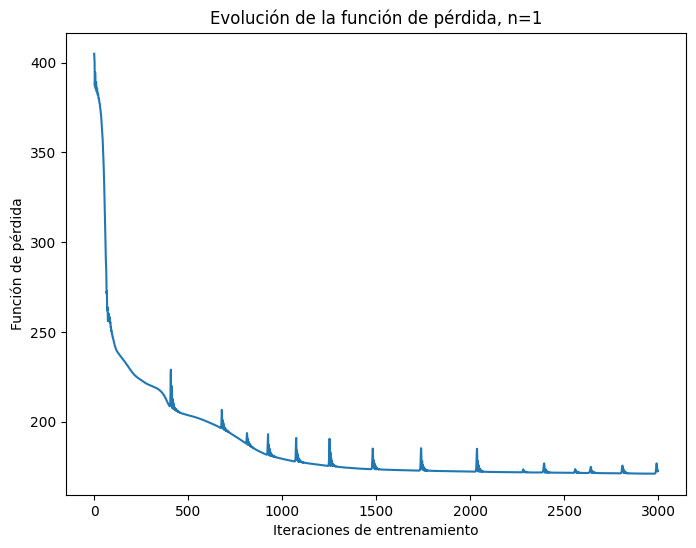

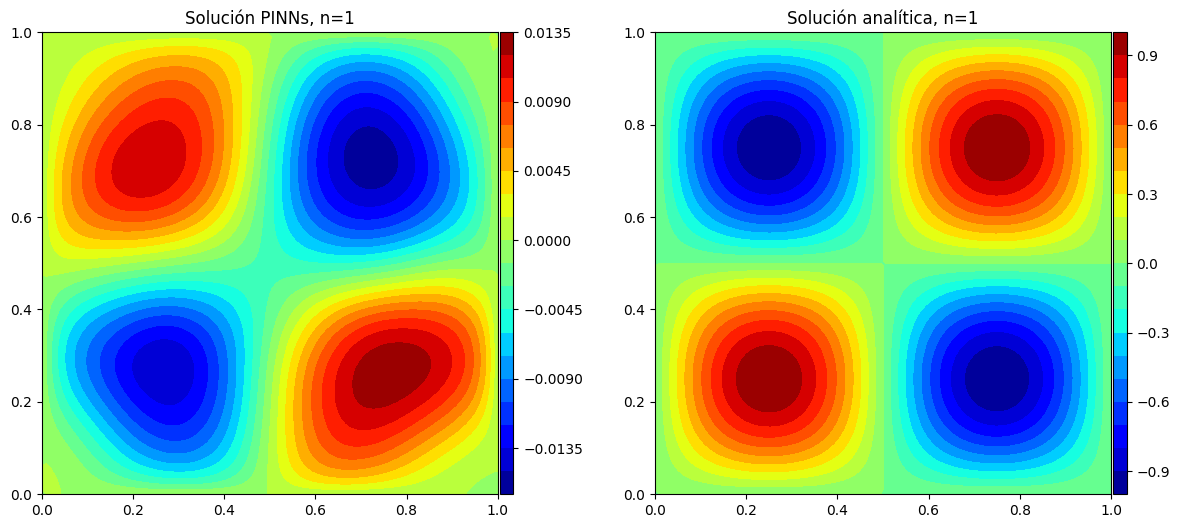

n=3, Iteration 500, Loss: 32211.986328125


KeyboardInterrupt: 

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Dimensión de input
dim_input = 2

# Dimensión de output
dim_output = 1

# Iteraciones del optimizador
iterations = 3000

# Geometría del dominio
geom = [0, 1, 0, 1]

# Condición de frontera
def boundary(x):
    return (x[:, 0] == 0) | (x[:, 0] == 1) | (x[:, 1] == 0) | (x[:, 1] == 1)

# Red neuronal totalmente conectada (FNN)
class FNN(nn.Module):
    def __init__(self, layers, activation):
        super(FNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Transformación para imponer la condición de borde
def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

# Ecuación en derivadas parciales (PDE)
def pde(x, y, net, k0):
    y = net(x)
    dy_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    dy_xx = torch.autograd.grad(dy_x[:, 0], x, grad_outputs=torch.ones_like(dy_x[:, 0]), create_graph=True)[0][:, 0]
    dy_yy = torch.autograd.grad(dy_x[:, 1], x, grad_outputs=torch.ones_like(dy_x[:, 1]), create_graph=True)[0][:, 1]
    f = k0 ** 2 * torch.sin(k0 * x[:, 0:1]) * torch.sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f

# Generación de datos de entrenamiento
num_domain = 500
x_train = np.random.rand(num_domain, dim_input)
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)

# Parámetros de la red
wide, n_layers, activation = 100, 3, torch.sin
layers = [dim_input] + [wide] * n_layers + [dim_output]

# Valores de n a considerar
n_values = [1, 3, 5]

for n in n_values:
    k0 = 2 * np.pi * n
    net = FNN(layers, activation)
    
    # Optimización
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    loss_history = []
    
    for i in range(iterations):
        optimizer.zero_grad()
        y_pred = transform(x_train, net(x_train))
        loss = pde(x_train, y_pred, net, k0).pow(2).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (i + 1) % 500 == 0:
            print(f"n={n}, Iteration {i + 1}, Loss: {loss.item()}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(iterations), loss_history)
    plt.xlabel("Iteraciones de entrenamiento")
    plt.ylabel("Función de pérdida")
    plt.title(f"Evolución de la función de pérdida, n={n}")
    plt.show()
    
    # Visualización de la solución
    def u_exact(x, y, k0):
        return np.sin(k0 * x) * np.sin(k0 * y)
    
    Nx, Ny = 100, 100
    x, y = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
    
    arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
    X_ = np.hstack(arrays)
    X_ = torch.tensor(X_.T, dtype=torch.float32)
    
    u = transform(X_, net(X_)).detach().numpy()
    
    X, Y = np.meshgrid(x, y)
    
    U_exact = u_exact(X, Y, k0)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)), levels=20, cmap='jet')
    ax[0].set_title(f"Solución PINNs, n={n}")
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c1, cax=cax, orientation='vertical')
    
    c2 = ax[1].contourf(X, Y, U_exact, levels=20, cmap='jet')
    ax[1].set_title(f"Solución analítica, n={n}")
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c2, cax=cax, orientation='vertical')
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()

A continuación, se aplicará Fourier features sobre esta RNN.
Descripción desde Perplexity AI:
Las Fourier Features son una técnica utilizada en el contexto de las Physics-Informed Neural Networks (PINNs) para mejorar su capacidad de aprender funciones de alta frecuencia en dominios de baja dimensión[1][3].

La idea principal es aplicar una transformación de características de Fourier a los puntos de entrada antes de pasarlos a la red neuronal. Esta transformación mapea los puntos de entrada a un espacio de características de mayor dimensión utilizando una matriz gaussiana aleatoria[1].

Esto tiene varios beneficios:

1. Permite a la red neuronal aprender funciones de alta frecuencia que de otra manera serían difíciles de capturar[1][3]. 

2. Transforma el kernel tangente neural (NTK) de la red en un kernel estacionario con un ancho de banda ajustable[1]. Esto da un mejor control sobre el espectro de la función recuperada.

3. Ayuda a las PINNs a converger más rápidamente y a evitar quedar atrapadas en mínimos locales o puntos de silla[3][5].

En resumen, las Fourier Features son una forma efectiva de incorporar información de frecuencia a las entradas de las PINNs, lo que mejora significativamente su capacidad de aprender funciones multi-escala y su rendimiento general en la resolución de ecuaciones diferenciales parciales[1][3][5].

Citations:
[1] https://bmild.github.io/fourfeat/
[2] https://www.mdpi.com/2311-5521/8/12/323
[3] https://www.sciencedirect.com/science/article/abs/pii/S0045782521002759
[4] https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4586276
[5] https://www.researchgate.net/publication/370009039_On_the_use_of_Fourier_Features-Physics_Informed_Neural_Networks_FF-PINN_for_forward_and_inverse_fluid_mechanics_problems


n=1, Iteration 500, Loss: 216.64553833007812
n=1, Iteration 1000, Loss: 206.68243408203125
n=1, Iteration 1500, Loss: 198.98133850097656
n=1, Iteration 2000, Loss: 193.50970458984375
n=1, Iteration 2500, Loss: 186.91368103027344
n=1, Iteration 3000, Loss: 181.21661376953125


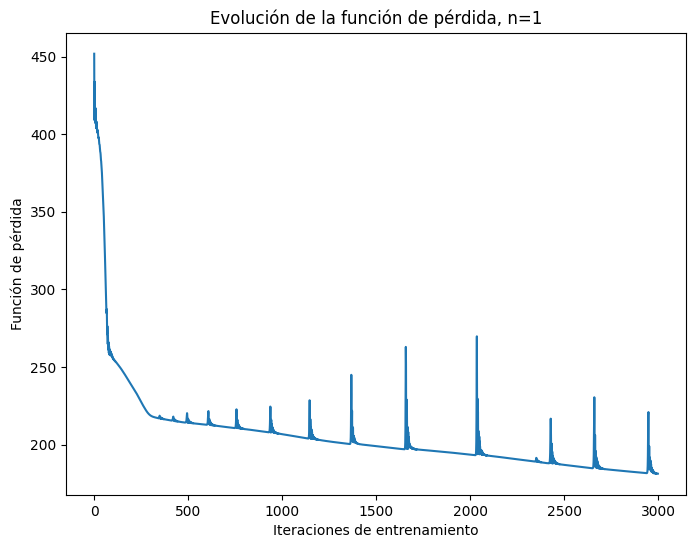

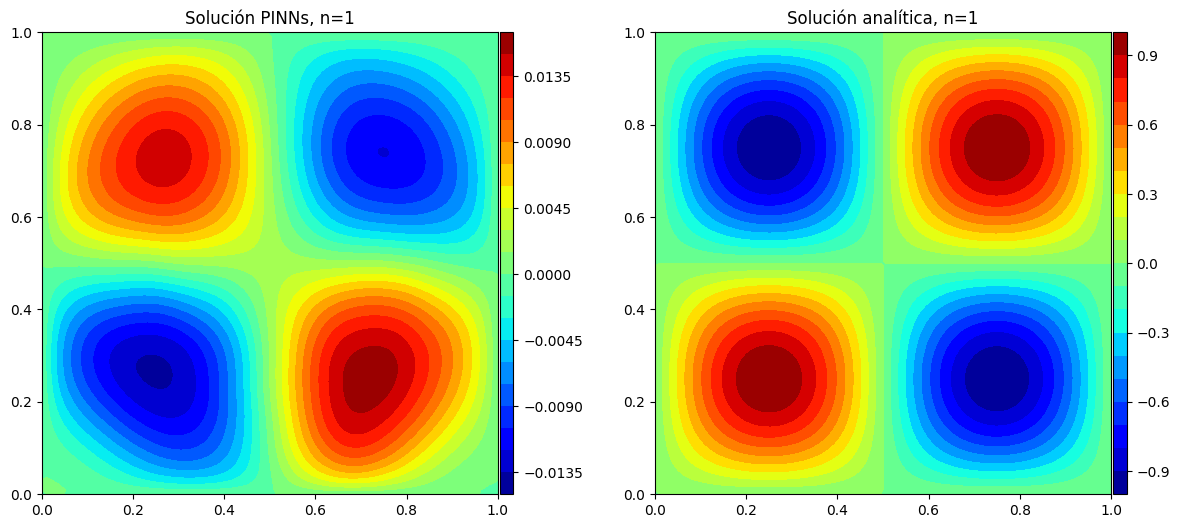

n=3, Iteration 500, Loss: 31920.50390625
n=3, Iteration 1000, Loss: 31234.736328125
n=3, Iteration 1500, Loss: 28850.986328125
n=3, Iteration 2000, Loss: 26855.7734375
n=3, Iteration 2500, Loss: 25133.12109375
n=3, Iteration 3000, Loss: 23664.427734375


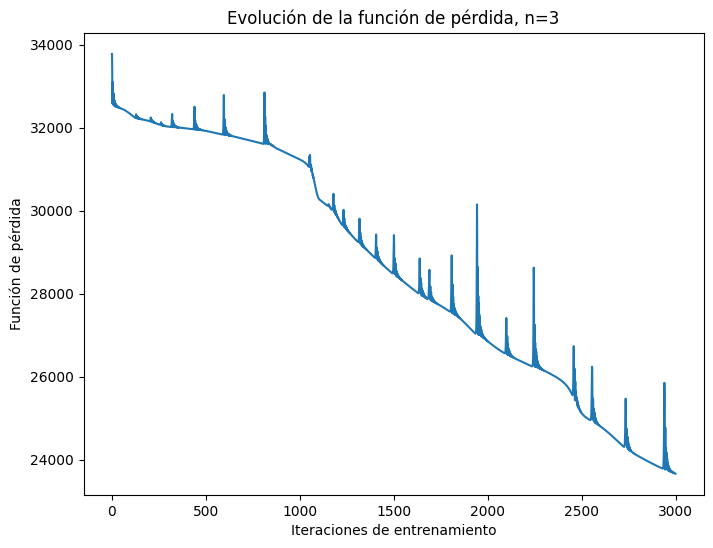

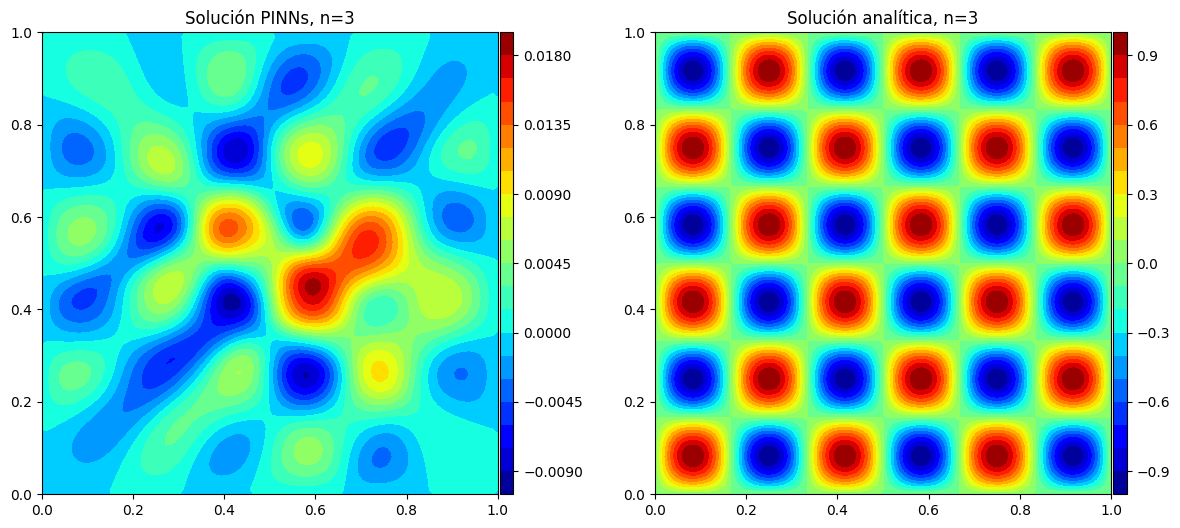

n=5, Iteration 500, Loss: 240324.75
n=5, Iteration 1000, Loss: 240063.734375
n=5, Iteration 1500, Loss: 239435.765625
n=5, Iteration 2000, Loss: 235765.4375
n=5, Iteration 2500, Loss: 231558.203125
n=5, Iteration 3000, Loss: 226360.3125


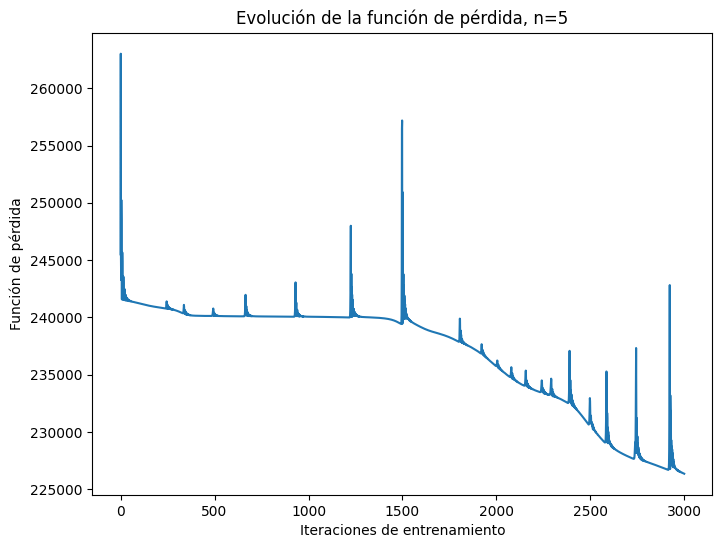

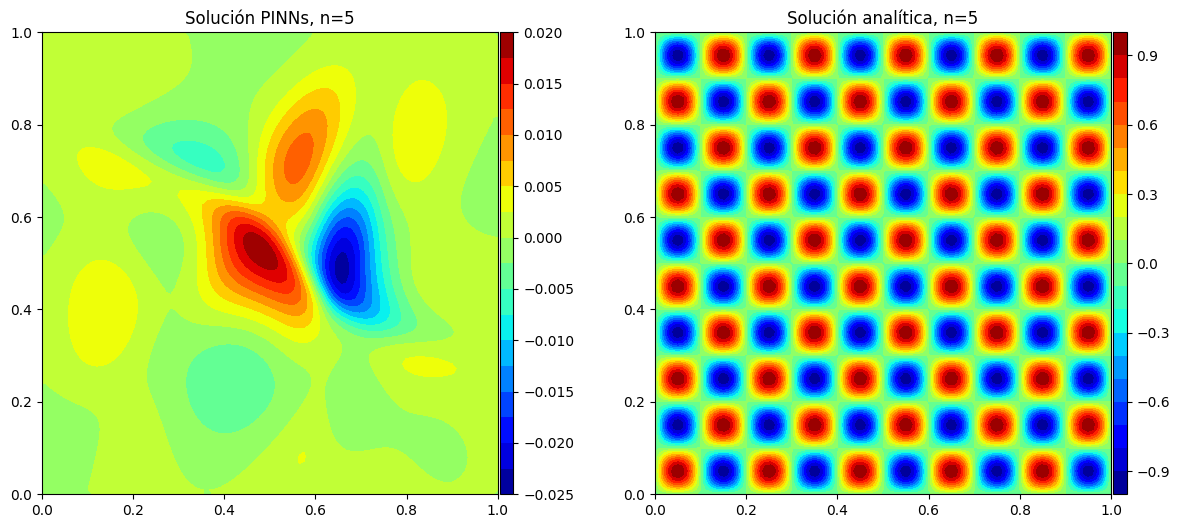

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Dimensión de input
dim_input = 2

# Dimensión de output
dim_output = 1

# Iteraciones del optimizador
iterations = 3000

# Geometría del dominio
geom = [0, 1, 0, 1]

# Condición de frontera
def boundary(x):
    return (x[:, 0] == 0) | (x[:, 0] == 1) | (x[:, 1] == 0) | (x[:, 1] == 1)

# Red neuronal totalmente conectada (FNN)
class FNN(nn.Module):
    def __init__(self, layers, activation):
        super(FNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Transformación para imponer la condición de borde
def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

# Ecuación en derivadas parciales (PDE)
def pde(x, y, net, k0):
    y = net(x)
    dy_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    dy_xx = torch.autograd.grad(dy_x[:, 0], x, grad_outputs=torch.ones_like(dy_x[:, 0]), create_graph=True)[0][:, 0]
    dy_yy = torch.autograd.grad(dy_x[:, 1], x, grad_outputs=torch.ones_like(dy_x[:, 1]), create_graph=True)[0][:, 1]
    f = k0 ** 2 * torch.sin(k0 * x[:, 0:1]) * torch.sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f

# Generación de datos de entrenamiento
num_domain = 1000
x_train = np.random.rand(num_domain, dim_input)
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)

# Parámetros de la red
wide, n_layers, activation = 100, 3, torch.tanh
layers = [dim_input] + [wide] * n_layers + [dim_output]

# Valores de n a considerar
n_values = [1, 3, 5]

for n in n_values:
    k0 = 2 * np.pi * n
    net = FNN(layers, activation)
    
    # Optimización
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    loss_history = []
    
    for i in range(iterations):
        optimizer.zero_grad()
        y_pred = transform(x_train, net(x_train))
        loss = pde(x_train, y_pred, net, k0).pow(2).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (i + 1) % 500 == 0:
            print(f"n={n}, Iteration {i + 1}, Loss: {loss.item()}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(iterations), loss_history)
    plt.xlabel("Iteraciones de entrenamiento")
    plt.ylabel("Función de pérdida")
    plt.title(f"Evolución de la función de pérdida, n={n}")
    plt.show()
    
    # Visualización de la solución
    def u_exact(x, y, k0):
        return np.sin(k0 * x) * np.sin(k0 * y)
    
    Nx, Ny = 100, 100
    x, y = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
    
    arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
    X_ = np.hstack(arrays)
    X_ = torch.tensor(X_.T, dtype=torch.float32)
    
    u = transform(X_, net(X_)).detach().numpy()
    
    X, Y = np.meshgrid(x, y)
    
    U_exact = u_exact(X, Y, k0)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)), levels=20, cmap='jet')
    ax[0].set_title(f"Solución PINNs, n={n}")
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c1, cax=cax, orientation='vertical')
    
    c2 = ax[1].contourf(X, Y, U_exact, levels=20, cmap='jet')
    ax[1].set_title(f"Solución analítica, n={n}")
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c2, cax=cax, orientation='vertical')
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()

Points=500, Activation=tanh, n=3, Iteration 500, Loss: 29732.408203125
Points=500, Activation=tanh, n=3, Iteration 1000, Loss: 27505.458984375
Points=500, Activation=tanh, n=3, Iteration 1500, Loss: 21761.4609375
Points=500, Activation=tanh, n=3, Iteration 2000, Loss: 20425.70703125
Points=500, Activation=tanh, n=3, Iteration 2500, Loss: 18372.947265625
Points=500, Activation=tanh, n=3, Iteration 3000, Loss: 15338.498046875


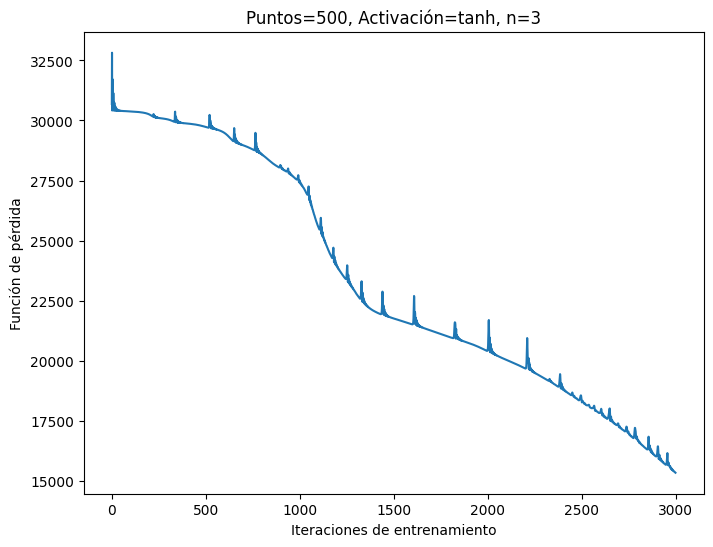

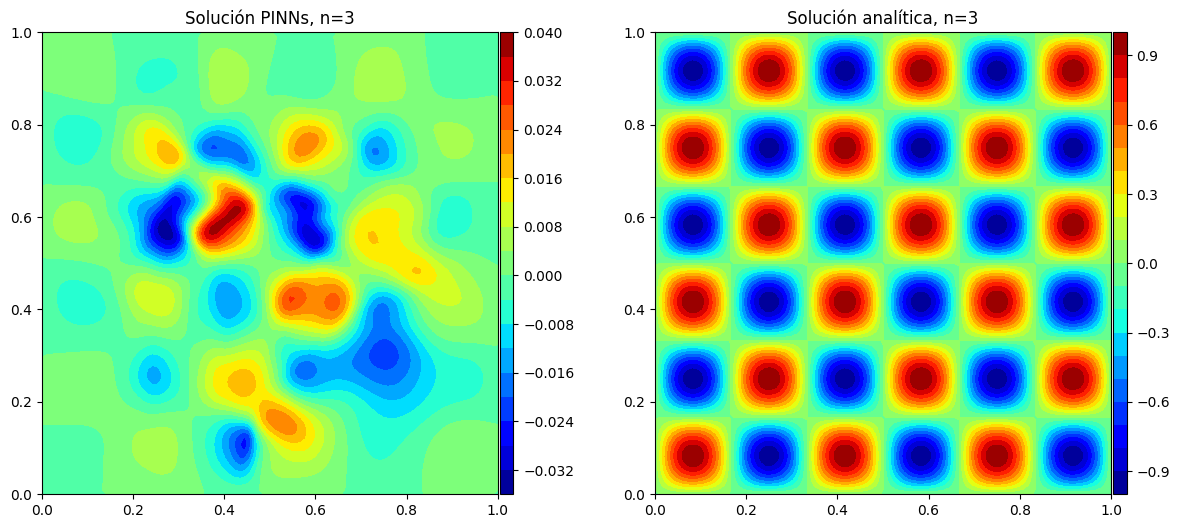

Points=500, Activation=relu, n=3, Iteration 500, Loss: 3124.127685546875
Points=500, Activation=relu, n=3, Iteration 1000, Loss: 725.6314086914062
Points=500, Activation=relu, n=3, Iteration 1500, Loss: 372.6220397949219
Points=500, Activation=relu, n=3, Iteration 2000, Loss: 255.33311462402344
Points=500, Activation=relu, n=3, Iteration 2500, Loss: 248.83352661132812
Points=500, Activation=relu, n=3, Iteration 3000, Loss: 227.76446533203125


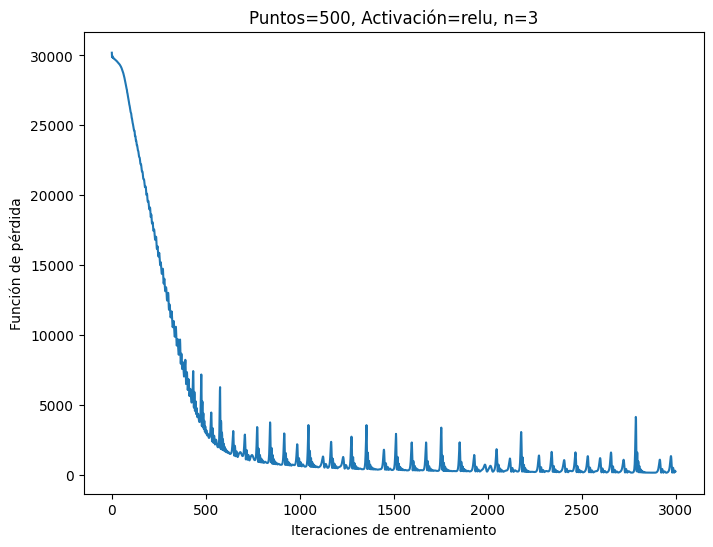

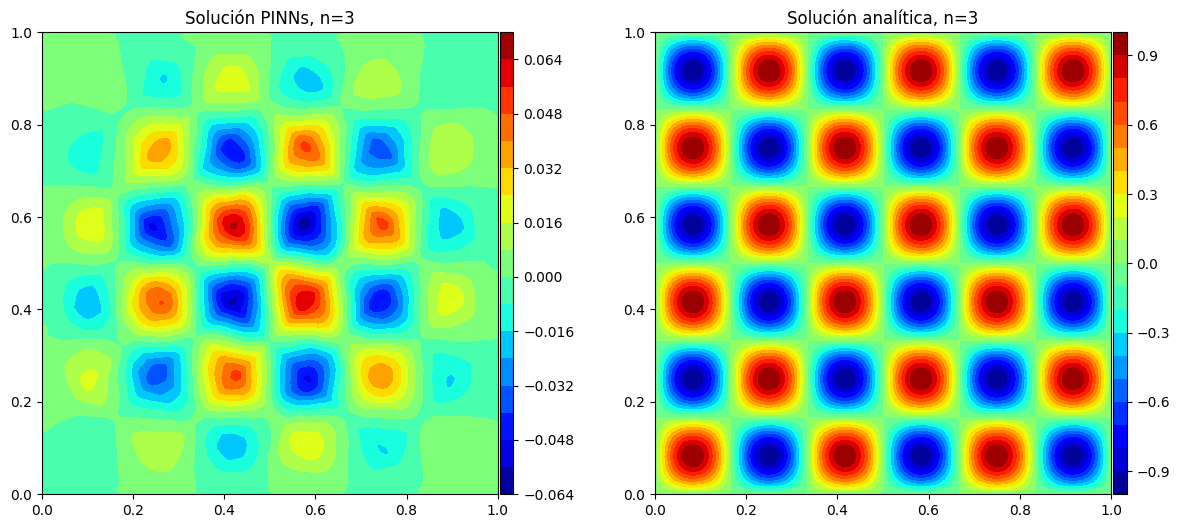

Points=1000, Activation=tanh, n=3, Iteration 500, Loss: 30584.212890625
Points=1000, Activation=tanh, n=3, Iteration 1000, Loss: 30053.205078125
Points=1000, Activation=tanh, n=3, Iteration 1500, Loss: 29410.611328125
Points=1000, Activation=tanh, n=3, Iteration 2000, Loss: 28259.892578125
Points=1000, Activation=tanh, n=3, Iteration 2500, Loss: 26376.626953125
Points=1000, Activation=tanh, n=3, Iteration 3000, Loss: 23547.9765625


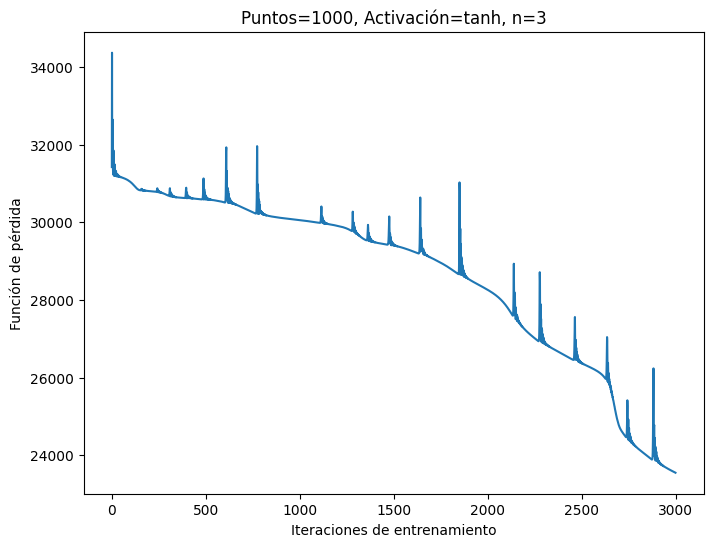

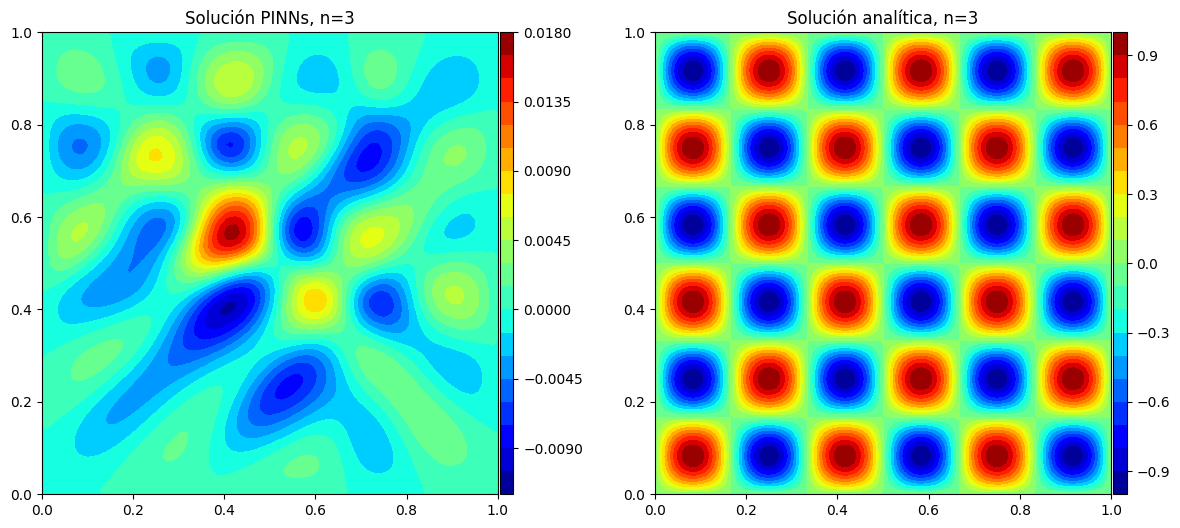

Points=1000, Activation=relu, n=3, Iteration 500, Loss: 7775.49609375
Points=1000, Activation=relu, n=3, Iteration 1000, Loss: 3215.69189453125
Points=1000, Activation=relu, n=3, Iteration 1500, Loss: 1724.4781494140625
Points=1000, Activation=relu, n=3, Iteration 2000, Loss: 1216.6796875
Points=1000, Activation=relu, n=3, Iteration 2500, Loss: 2745.168701171875
Points=1000, Activation=relu, n=3, Iteration 3000, Loss: 755.7108764648438


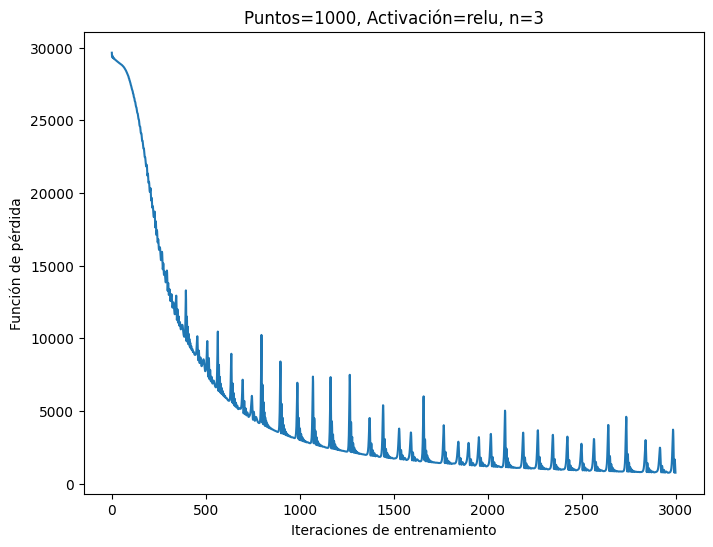

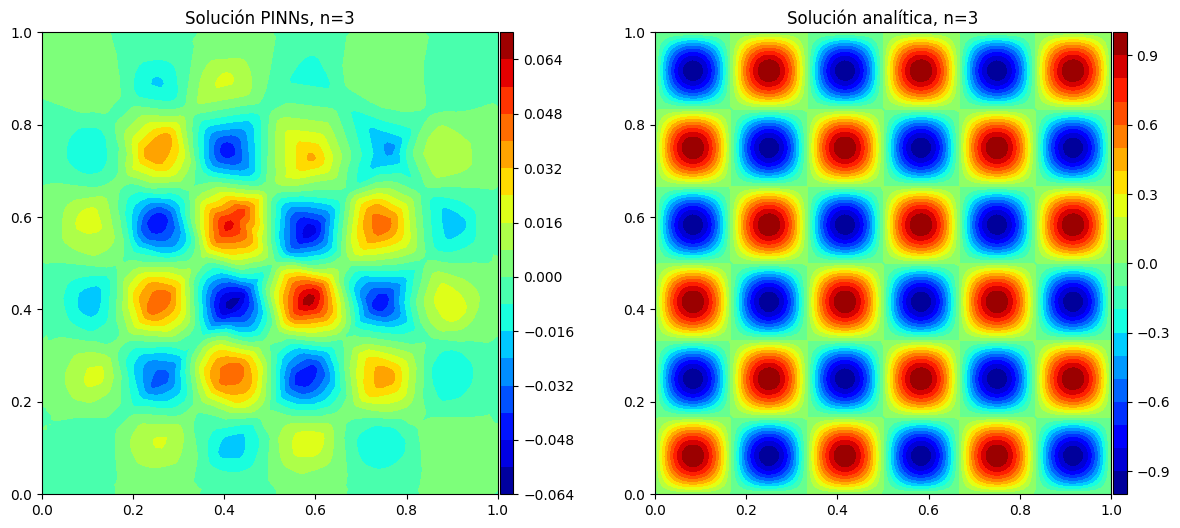

Points=1500, Activation=tanh, n=3, Iteration 500, Loss: 30232.34375
Points=1500, Activation=tanh, n=3, Iteration 1000, Loss: 30160.75390625
Points=1500, Activation=tanh, n=3, Iteration 1500, Loss: 29623.404296875
Points=1500, Activation=tanh, n=3, Iteration 2000, Loss: 27853.6328125
Points=1500, Activation=tanh, n=3, Iteration 2500, Loss: 24990.013671875
Points=1500, Activation=tanh, n=3, Iteration 3000, Loss: 22668.7734375


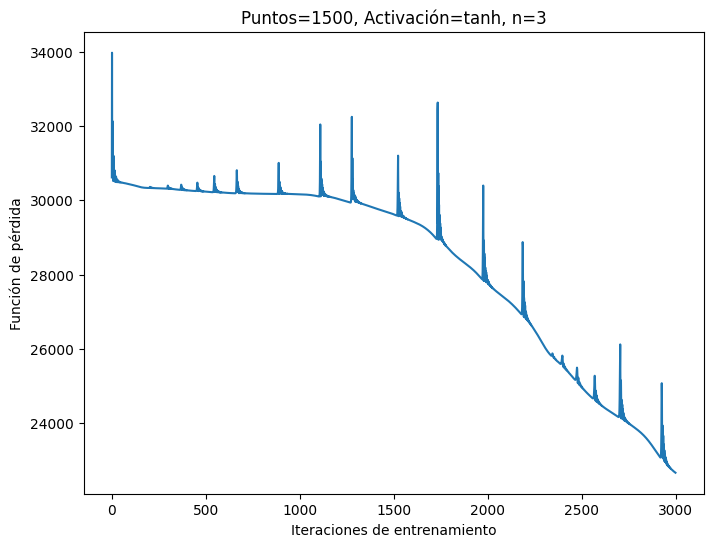

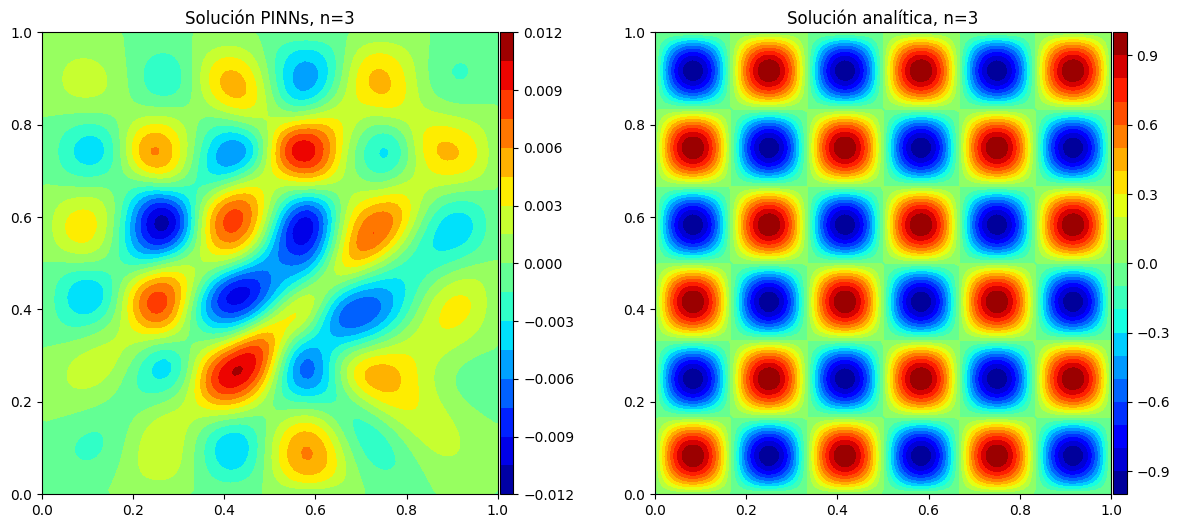

Points=1500, Activation=relu, n=3, Iteration 500, Loss: 16065.0341796875
Points=1500, Activation=relu, n=3, Iteration 1000, Loss: 5157.2236328125
Points=1500, Activation=relu, n=3, Iteration 1500, Loss: 2376.043701171875
Points=1500, Activation=relu, n=3, Iteration 2000, Loss: 1283.7503662109375
Points=1500, Activation=relu, n=3, Iteration 2500, Loss: 735.9685668945312
Points=1500, Activation=relu, n=3, Iteration 3000, Loss: 642.5021362304688


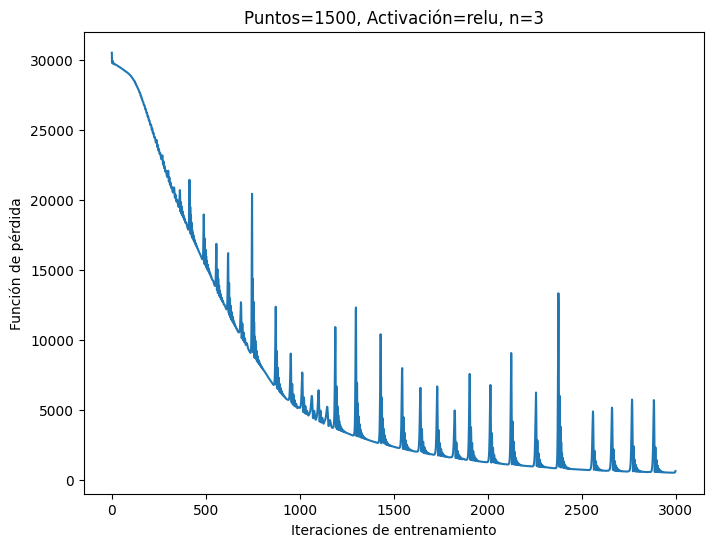

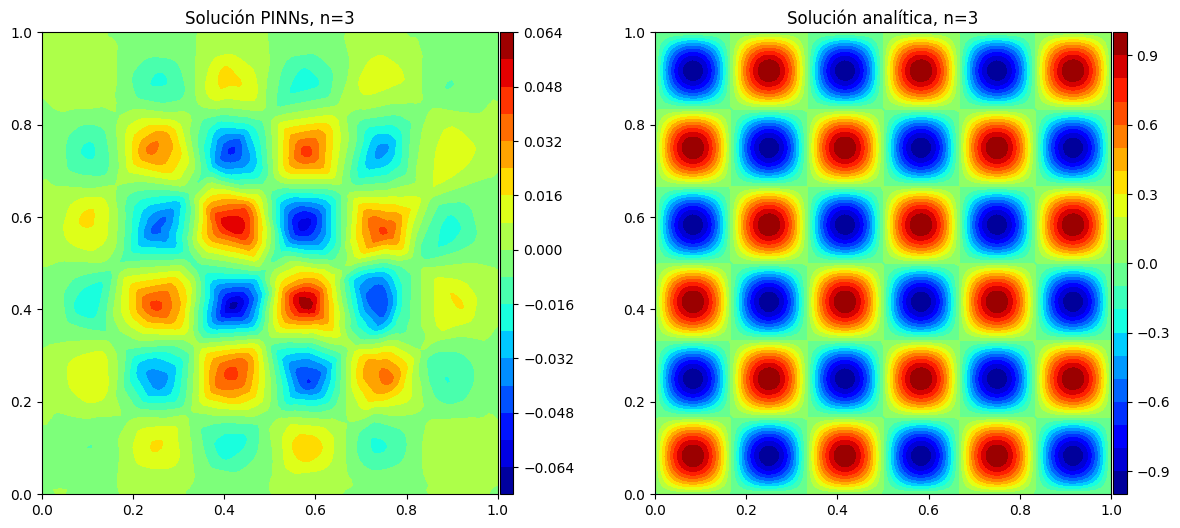

In [10]:
# Generación de datos de entrenamiento
def generate_training_data(num_domain):
    x_train = np.random.rand(num_domain, dim_input)
    x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)
    return x_train

# Parámetros de la red
wide, n_layers = 100, 3
layers = [dim_input] + [wide] * n_layers + [dim_output]

# Combinaciones de puntos de colocación y funciones de activación
point_combinations = [500, 1000, 1500]
activation_functions = [torch.tanh, torch.relu] #es posible agregar torch.sigmoid

n_values=[3]

for num_points in point_combinations:
    for activation in activation_functions:
        x_train = generate_training_data(num_points)
        
        for n in n_values:
            k0 = 2 * np.pi * n
            net = FNN(layers, activation)
            
            # Optimización
            optimizer = optim.Adam(net.parameters(), lr=1e-3)
            
            loss_history = []
            
            for i in range(iterations):
                optimizer.zero_grad()
                y_pred = transform(x_train, net(x_train))
                loss = pde(x_train, y_pred, net, k0).pow(2).mean()
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())
                if (i + 1) % 500 == 0:
                    print(f"Points={num_points}, Activation={activation.__name__}, n={n}, Iteration {i + 1}, Loss: {loss.item()}")
            
            plt.figure(figsize=(8, 6))
            plt.plot(range(iterations), loss_history)
            plt.xlabel("Iteraciones de entrenamiento")
            plt.ylabel("Función de pérdida")
            plt.title(f"Puntos={num_points}, Activación={activation.__name__}, n={n}")
            plt.show()
            
            # Visualización de la solución
            def u_exact(x, y, k0):
                return np.sin(k0 * x) * np.sin(k0 * y)
            
            Nx, Ny = 100, 100
            x, y = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
            
            arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
            X_ = np.hstack(arrays)
            X_ = torch.tensor(X_.T, dtype=torch.float32)
            
            u = transform(X_, net(X_)).detach().numpy()
            
            X, Y = np.meshgrid(x, y)
            
            U_exact = u_exact(X, Y, k0)
            
            fig, ax = plt.subplots(1, 2, figsize=(14, 6))
            
            c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)), levels=20, cmap='jet')
            ax[0].set_title(f"Solución PINNs, n={n}")
            
            divider = make_axes_locatable(ax[0])
            cax = divider.append_axes('right', size='3%', pad=0.02)
            fig.colorbar(c1, cax=cax, orientation='vertical')
            
            c2 = ax[1].contourf(X, Y, U_exact, levels=20, cmap='jet')
            ax[1].set_title(f"Solución analítica, n={n}")
            
            divider = make_axes_locatable(ax[1])
            cax = divider.append_axes('right', size='3%', pad=0.02)
            fig.colorbar(c2, cax=cax, orientation='vertical')
            
            plt.subplots_adjust(wspace=0.3)
            plt.show()

Acá hay que correr el código y elegir la mejor combinación, luego a esa combinación de puntos de colocación y función de activación se le aplicará Fourier features, en el siguiente código: 

n=1, Iteration 500, Loss: 7816.41796875
n=1, Iteration 1000, Loss: 3659.072509765625
n=1, Iteration 1500, Loss: 3472.43310546875
n=1, Iteration 2000, Loss: 1219.1041259765625
n=1, Iteration 2500, Loss: 3591.5693359375
n=1, Iteration 3000, Loss: 1141.8775634765625


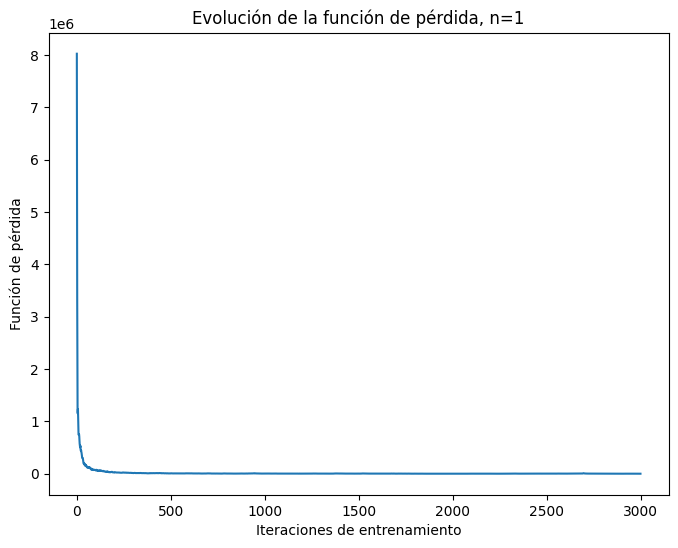

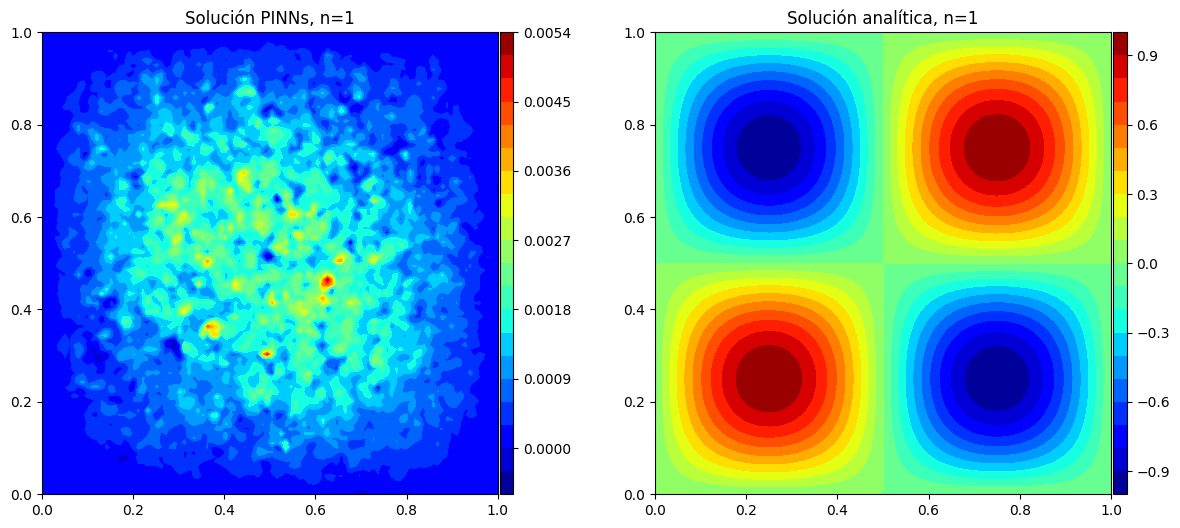

n=3, Iteration 500, Loss: 57137.3359375
n=3, Iteration 1000, Loss: 30304.94140625
n=3, Iteration 1500, Loss: 12391.265625
n=3, Iteration 2000, Loss: 6031.68505859375
n=3, Iteration 2500, Loss: 5634.28466796875
n=3, Iteration 3000, Loss: 2614.899658203125


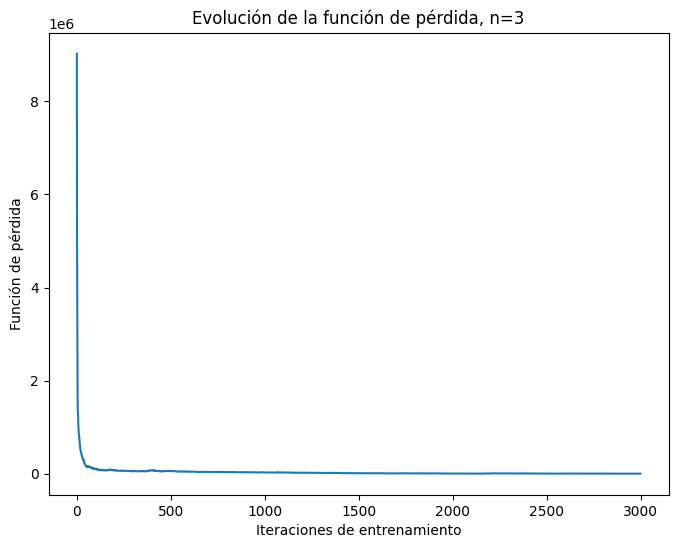

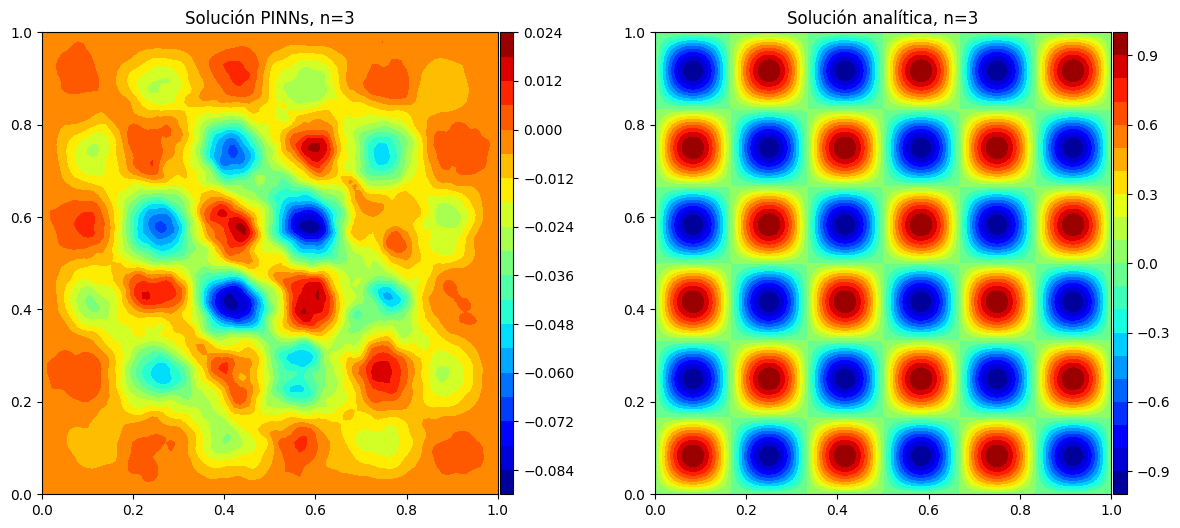

n=5, Iteration 500, Loss: 73741.265625
n=5, Iteration 1000, Loss: 19900.255859375
n=5, Iteration 1500, Loss: 10145.80859375
n=5, Iteration 2000, Loss: 4118.97119140625
n=5, Iteration 2500, Loss: 2576.80810546875
n=5, Iteration 3000, Loss: 2916.688720703125


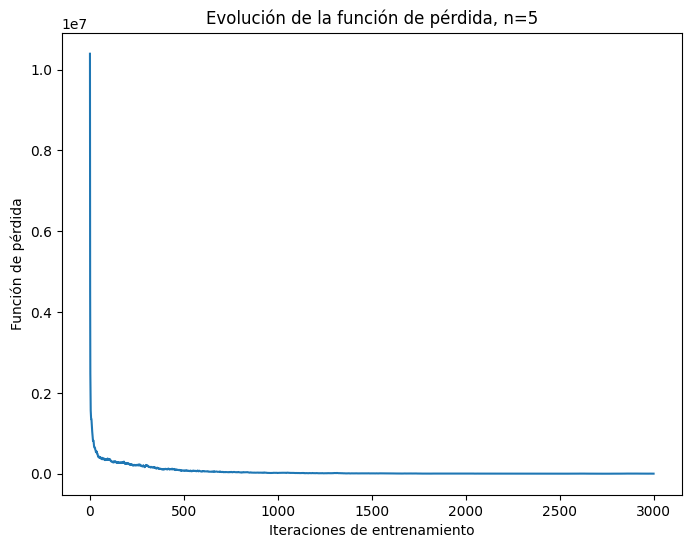

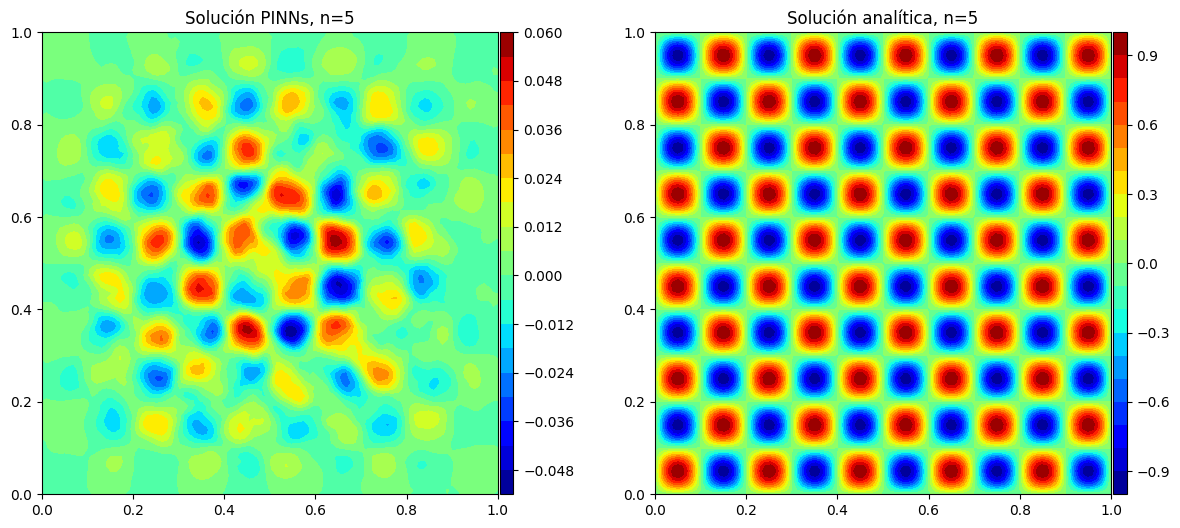

In [ ]:
## Este código al parecer no está funcionando bien, quizás hay que corregir la implementación del problema (dice chatgpt)
## Está indicado donde aplicar los cambios a los puntos de colocación y la función de activación


# Dimensión de input
dim_input = 2

# Dimensión de output
dim_output = 1

# Iteraciones del optimizador
iterations = 3000

# Geometría del dominio
geom = [0, 1, 0, 1]

# Fourier Features
class FourierFeatures(nn.Module):
    def __init__(self, input_dim, mapping_size=256, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.B = torch.randn((input_dim, mapping_size)) * scale

    def forward(self, x):
        x_proj = 2.0 * np.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# Condición de frontera
def boundary(x):
    return (x[:, 0] == 0) | (x[:, 0] == 1) | (x[:, 1] == 0) | (x[:, 1] == 1)

# Red neuronal totalmente conectada (FNN)
class FNN(nn.Module):
    def __init__(self, layers, activation):
        super(FNN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = activation
    
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Transformación para imponer la condición de borde
def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

# Ecuación en derivadas parciales (PDE)
def pde(x, y, net, k0):
    x_ff = fourier_features(x)  # Transformar x usando FourierFeatures
    y = net(x_ff)
    dy_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    dy_xx = torch.autograd.grad(dy_x[:, 0], x, grad_outputs=torch.ones_like(dy_x[:, 0]), create_graph=True)[0][:, 0]
    dy_yy = torch.autograd.grad(dy_x[:, 1], x, grad_outputs=torch.ones_like(dy_x[:, 1]), create_graph=True)[0][:, 1]
    f = k0 ** 2 * torch.sin(k0 * x[:, 0:1]) * torch.sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f

# Generación de datos de entrenamiento
num_domain = 500  # Ajustar puntos de colocación al optimo encontrado antes
x_train = np.random.rand(num_domain, dim_input)
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True)

# Parámetros de la red
wide, n_layers, activation = 100, 4, torch.relu  # Cambiar la función de activación a la optima encontrada antes
mapping_size = 256  # Definir el tamaño de mapeo de Fourier Features
layers = [2 * mapping_size] + [wide] * n_layers + [dim_output]  # Ajustar capas según Fourier Features

# Valores de n a considerar
n_values = [1, 3, 5]

for n in n_values:
    k0 = 2 * np.pi * n
    fourier_features = FourierFeatures(dim_input, mapping_size=mapping_size)
    net = FNN(layers, activation)
    
    # Inicialización Xavier 
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
    net.apply(init_weights)
    
    # Optimización
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    loss_history = []
    
    for i in range(iterations):
        optimizer.zero_grad()
        x_ff = fourier_features(x_train)
        y_pred = transform(x_train, net(x_ff))
        loss = pde(x_train, y_pred, net, k0).pow(2).mean()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (i + 1) % 500 == 0:
            print(f"n={n}, Iteration {i + 1}, Loss: {loss.item()}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(iterations), loss_history)
    plt.xlabel("Iteraciones de entrenamiento")
    plt.ylabel("Función de pérdida")
    plt.title(f"Evolución de la función de pérdida, n={n}")
    plt.show()
    
    # Visualización de la solución
    def u_exact(x, y, k0):
        return np.sin(k0 * x) * np.sin(k0 * y)
    
    Nx, Ny = 100, 100
    x, y = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)
    
    arrays = [np.vstack((x, np.ones(Nx) * y[i])) for i in range(Ny)]
    X_ = np.hstack(arrays)
    X_ = torch.tensor(X_.T, dtype=torch.float32)
    
    x_ff = fourier_features(X_)
    u = transform(X_, net(x_ff)).detach().numpy()
    
    X, Y = np.meshgrid(x, y)
    
    U_exact = u_exact(X, Y, k0)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)), levels=20, cmap='jet')
    ax[0].set_title(f"Solución PINNs, n={n}")
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c1, cax=cax, orientation='vertical')
    
    c2 = ax[1].contourf(X, Y, U_exact, levels=20, cmap='jet')
    ax[1].set_title(f"Solución analítica, n={n}")
    
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='3%', pad=0.02)
    fig.colorbar(c2, cax=cax, orientation='vertical')
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()
